In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
%matplotlib inline

In [2]:
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=6):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

In [3]:
##Temporal kernal
def temporal(t):
    k1 = 2.2
    sigma_1 = 1
    u1 = 3
    k2 = 2
    sigma_2 = 2
    u2 = 8
    kernal1 = (k1/np.sqrt(2*np.pi)/sigma_1)*np.exp(-(t-u1)**2/(2*sigma_1**2))
    kernal2 = (k2/np.sqrt(2*np.pi)/sigma_2)*np.exp(-(t-u2)**2/(2*sigma_2**2))
    return kernal1-kernal2

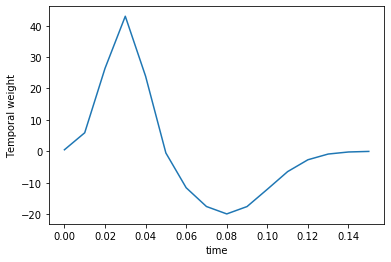

In [4]:
#Make Temporal kernal
length = 15
dt = 0.01
tp = temporal(np.arange(0,length+1))
tp = tp*50
plt.plot(np.arange(0,length+1)*dt,tp)
plt.xlabel('time')
plt.ylabel('Temporal weight')
temp_pre = np.zeros(length)
tp = np.concatenate((temp_pre,tp))

In [5]:
#Spatial kernal
def spatial(x,u):
    sigma_1 = 0.5
    sigma_2 = 2
    kernal1 = (5/np.sqrt(2*np.pi)/sigma_1)*np.exp(-(x-u)**2/(2*sigma_1**2))
    kernal2 = (5/np.sqrt(2*np.pi)/sigma_2)*np.exp(-(x-u)**2/(2*sigma_2**2))
    return kernal1-kernal2

Text(0, 0.5, 'Spatial weight')

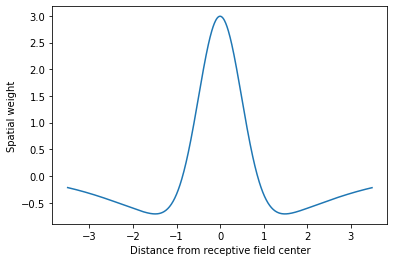

In [6]:
#Make Spatial kernal
sigma_c = 1#RF size of horizontal cell
dx = 0.01*sigma_c
sk = spatial(np.arange(-3.5*sigma_c,3.5*sigma_c,dx),0)
plt.plot(np.arange(-3.5*sigma_c,3.5*sigma_c,dx),sk)
plt.xlabel('Distance from receptive field center')
plt.ylabel('Spatial weight')

In [7]:
#Gain control function
def gain(v,order,B):
    if v <0:
        return 1
    else:
        return 1/(1+(B*v)**order)

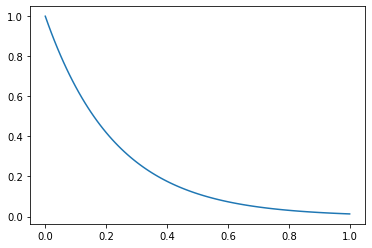

In [8]:
#Feedback filter for u
tau = 0.23#sec
feedback_filter = np.exp(-np.arange(0,1+dt,dt)/tau)
plt.plot(np.arange(0,1+dt,dt),feedback_filter)

In [9]:
#Width setting
xlen = 15*sigma_c#spatial extend of simulation
hw = 0.5*sigma_c#half bar width

In [10]:
pos_0 = 7.5*sigma_c#Where the bar start
nstep = 3000#time step of simulation
velocity = 1*sigma_c#speed of bar
order = 4#Order of gain control
B = 20#To tune altitude of gain control
contrast = 1#Contrast of bar
real_len = int(xlen/dx)#spatial width
#OU parameter
tau= 1
D = 27*10**5
mu, sigma = 0,1
#MI variable
dms = np.arange(-99,100)#Time shift
total_frequency = [0.5,1,2,4]#Cutoff frequency
total_mi_no_gain = np.zeros([len(total_frequency),len(dms)])#MI between trajectory and linear output
total_mi_gain = np.zeros([len(total_frequency),len(dms)])#MI between trajectory and responses of middle ganglion cell

In [11]:
#Produce OU series
OU=np.zeros(nstep)
for i in range(nstep-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)


for o in range(len(total_frequency)):
    cutoffFreq = total_frequency[o]
    # filtering for LPOU
    b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
    LPOU = signal.filtfilt(b, a, OU)
    
    s = np.zeros([real_len,nstep])#stimulus
    u = np.zeros([real_len,nstep])#Output
    speak = np.zeros(nstep)
    gains = np.zeros([real_len,nstep])#Gain values
    #Produce stimulus
    for i in range(nstep):
        #Bar position
        pos = pos_0+LPOU[i]/700
        speak[i] = pos
        #Stimulus of bar
        s[int((pos-hw)/dx):int((pos+hw)/dx),i] = contrast
    
    ##Produce spatial-temporal filter
    temp = np.zeros([real_len,nstep])
    spatial_temp1 = np.zeros([real_len,nstep])#For further gain control
    for i in range(nstep):
        temp[:,i] = np.convolve(s[:,i],sk,'same')*dx
    for j in range(real_len):
        spatial_temp1[j,:] = np.convolve(tp,temp[j,:],'same')*dt
    temp = np.zeros([real_len,nstep])
    spatial_temp2 = np.zeros([real_len,nstep])#Linear filter output, this represents convolution between input and spatial-temporal filter
    for j in range(real_len):
        temp[j,:] = np.convolve(tp,s[j,:],'same')*dt
    for i in range(nstep):
        spatial_temp2[:,i] = np.convolve(temp[:,i],sk,'same')*dx

    
    #######Main part##########
    for i in range(len(feedback_filter),nstep,1):
        for j in range(real_len):
            v = np.convolve(feedback_filter,spatial_temp1[j,i-len(feedback_filter)+1:i+1],'valid')*dt#average by expotential filtering
            g = gain(v,order,B)#Gain control
            spatial_temp1[j,i] = spatial_temp1[j,i]*g
            u[j,i] = spatial_temp1[j,i]#*g
            gains[j,i] = g

    ###Nonlinearity
    u[u<0]= 0####Make negative number to zero
    ##Gain control doesn't improve anticipation
    index = int(pos_0/dx)
    response_gain = spatial_temp1[index][len(tp):]#spatial_temp1 is the result of convolution and add gain control
    response_no_gain = spatial_temp2[index][len(tp):]#spatial_temp2 is the result of convolution
    mi_gain = [mi_quick(LPOU[len(tp):],response_gain,d) for d in dms]
    mi_no_gain = [mi_quick(LPOU[len(tp):],response_no_gain,d) for d in dms]
    total_mi_gain[o,:] = mi_gain
    total_mi_no_gain[o,:] = mi_no_gain

0.5Hz
peak with gain 0.18sec
peak with no gain 0.19sec
 
1Hz
peak with gain 0.09sec
peak with no gain 0.07sec
 
2Hz
peak with gain 0.05sec
peak with no gain -0.01sec
 
4Hz
peak with gain -0.02sec
peak with no gain -0.05sec
 


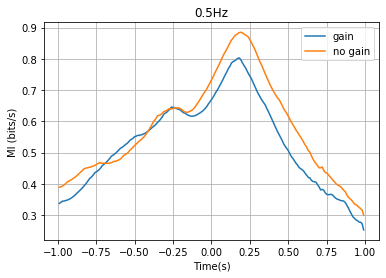

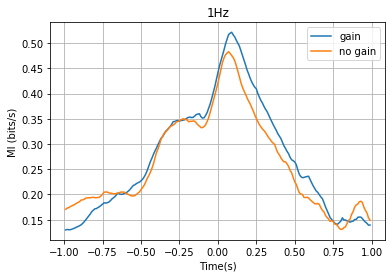

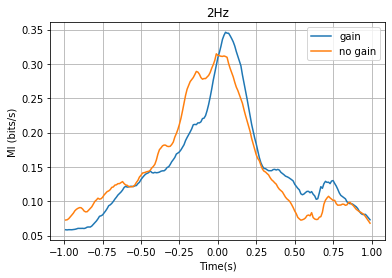

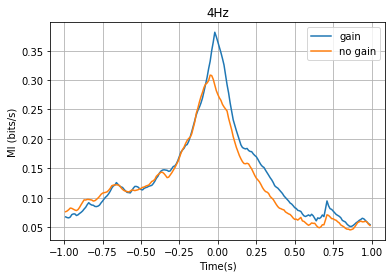

In [12]:
for i in range(len(total_frequency)):
    plt.figure()
    plt.title(str(total_frequency[i])+'Hz')
    plt.plot(dms*dt,total_mi_gain[i,:],label='gain')
    plt.plot(dms*dt,total_mi_no_gain[i,:],label='no gain')
    plt.grid()
    plt.legend()
    plt.xlabel('Time(s)')
    plt.ylabel('MI (bits/s)')
    print(str(total_frequency[i])+'Hz')
    print('peak with gain '+str(dms[np.argmax(total_mi_gain[i,:])]*dt)+'sec')
    print('peak with no gain '+str(dms[np.argmax(total_mi_no_gain[i,:])]*dt)+'sec')
    print(' ')
#plt.savefig('different_frequency_berry.jpg')